In [1]:
import pandas as pd
import seaborn as sns
import numpy as np  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from skimage import io
from skimage.feature import hog
from joblib import Parallel, delayed
import cv2
import glob
import os

import pyarrow

In [2]:
# specify data log pathway
path_key = r'.\data_log_20201009.xlsx'
path_data = r'C\:'

# specify camera names
cams = ['cam1', 'cam2']

# specify image extension
extension = ['tiff']

In [3]:
# read key
key = pd.read_excel(path_key) [['exp',
                                'date',
                                'subject',
                                'video_rec',
                                'path_tr', 
                                'hogs', 
                                'cam1_crop_0', 
                                'cam1_crop_1',
                                'cam1_crop_2',
                                'cam1_crop_3',
                                'cam2_crop_0',
                                'cam2_crop_1',
                                'cam2_crop_2',
                                'cam2_crop_3']]

# filter to sessions with video recording
key = key.loc[key.video_rec == 1].reset_index(drop = True)

# filter to sessions without hogs
key = key.loc[key.hogs == 0].reset_index(drop = True)

key

,exp,date,subject,video_rec,path_tr,hogs,cam1_crop_0,cam1_crop_1,cam1_crop_2,cam1_crop_3,cam2_crop_0,cam2_crop_1,cam2_crop_2,cam2_crop_3
0,aac,2020-10-18,aac16,1.0,C:\Users\stuberadmin\Desktop\data_pylon\2020_1...,0.0,0.0,0.0,1280.0,960.0,0.0,0.0,1280.0,960.0
1,aac,2020-10-18,aac17,1.0,C:\Users\stuberadmin\Desktop\data_pylon\2020_1...,0.0,0.0,0.0,1280.0,960.0,0.0,0.0,1280.0,960.0


In [4]:
###Preprocessing
#manually select the area containing the head of the mouse, 
#which will save the coordinates into a variable, to be used later.

def findCropCoords(imgFolderAndFileType):
    ###accepts folder containing image files in format "D:/folder1/folder2/folder3/*.jpg"
    ###waits for user to draw a rectangular selection
    ###outputs coordinates of a rectangular selection drawn over an image
    ###by default, the image displayed is the second image in the input folder
    import cv2
    from skimage import io
    
    coll = io.ImageCollection(imgFolderAndFileType)
    coords1 = cv2.selectROI("Image", coll[1]) 
    
    #cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return coords1

#replace the filepath below and uncomment for own use. In all following examples a set of preselected coordinated will be used 
#(imported in the cell above as proto_cropCoords)
#coords_1 = findCropCoords("D:/folder1/folder2/folder3/*.jpg")

In [5]:
###Data loading and preprocessing
#the imagesToHogsCellCrop() function will take all image files in a given folder, 
#crop the area as given in the cropCoords (use findCropCoords()) 
#and convert them into their HOG (histogram of oriented gradients) descriptors.
#pixels_per_cell argument defines the sliding window size for HOG creation.
# n_jobs argument defines number of threads used

def imagesToHogsCellCrop(imgFolderAndFileType, pixelsPerCell, cropCoords = []):
    from skimage import io
    from skimage.feature import hog
    from joblib import Parallel, delayed
    
    coll = io.ImageCollection(imgFolderAndFileType)
    
    if cropCoords == []:
        cropCoords = findCropCoords(imgFolderAndFileType)
    
    r = cropCoords
    
    kwargs = dict(orientations=8, pixels_per_cell=(pixelsPerCell, pixelsPerCell), cells_per_block=(1, 1), transform_sqrt=True)
    return Parallel(n_jobs=32)(delayed(hog)(image[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])], **kwargs) for image in coll)


#replace the filepath below for own use

In [6]:
session_to_display = 1

key.path_tr[session_to_display]

'C:\\Users\\stuberadmin\\Desktop\\data_pylon\\2020_10_11_aac17_d03_rereplete'

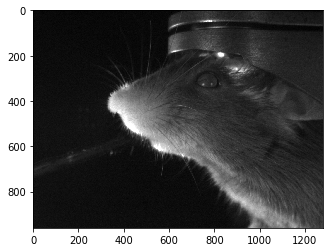

In [7]:
# display cam1
path_img = glob.glob(os.path.join(path_data, key.path_tr[session_to_display] + '\\cam1\\*.tiff'))[0]
plt.imshow(mpimg.imread(path_img), cmap="gray")

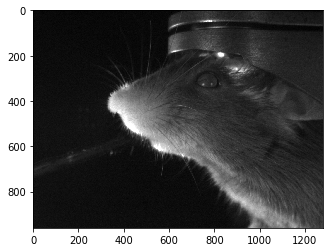

In [8]:
###example image - cropped
proto_cropCoords = (key.cam1_crop_0[session_to_display],
                    key.cam1_crop_1[session_to_display], 
                    key.cam1_crop_2[session_to_display],
                    key.cam1_crop_3[session_to_display])



r = proto_cropCoords
plt.imshow(mpimg.imread(path_img)[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])], cmap="gray")

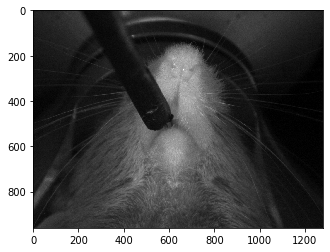

In [9]:
# display cam2
path_img = glob.glob(os.path.join(path_data, key.path_tr[session_to_display] + '\\cam2\\*.tiff'))[0]
plt.imshow(mpimg.imread(path_img), cmap="gray")

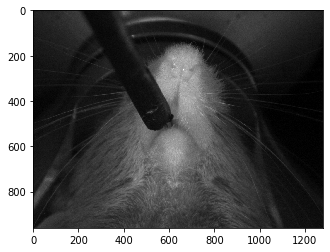

In [10]:
###example image - cropped
proto_cropCoords2 = (key.cam2_crop_0[session_to_display],
                     key.cam2_crop_1[session_to_display], 
                     key.cam2_crop_2[session_to_display],
                     key.cam2_crop_3[session_to_display])

r = proto_cropCoords2
plt.imshow(mpimg.imread(path_img)[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])], cmap="gray")

In [11]:
folders = key.path_tr

loop_n = 0

for folder in folders:
    print("processing: " + folder)
    
    print("converting cam1 tiffs to hogs...")
    loop_dat_cam1 = imagesToHogsCellCrop(os.path.join(path_data, folder + '\\cam1\\*.tiff'), 32, cropCoords = proto_cropCoords)
    
    print("converting cam2 tiffs to hogs...")
    loop_dat_cam2 = imagesToHogsCellCrop(os.path.join(path_data, folder + '\\cam2\\*.tiff'), 32, cropCoords = proto_cropCoords2) 
    
    cam1_hog = pd.DataFrame(loop_dat_cam1)
    cam1_hog.columns = cam1_hog.columns.astype('str')
    
    cam1_tm = pd.DataFrame({'hog_tm': np.arange(0,len(loop_dat_cam1),1) / 25})
    
    print("saving cam1 hogs as .feather...")
    cam1_hog.to_feather(os.path.join(path_data, folder) + '/cam1_hog.feather')
    cam1_tm.to_feather(os.path.join(path_data, folder) + '/cam1_hog_tm.feather')
    
    
    cam2_hog = pd.DataFrame(loop_dat_cam2)
    cam2_hog.columns = cam2_hog.columns.astype('str')
    
    cam2_tm = pd.DataFrame({'hog_tm': np.arange(0,len(loop_dat_cam2),1) / 25})
    
    print("saving cam2 hogs as .feather...")
    cam2_hog.to_feather(os.path.join(path_data, folder) + '/cam2_hog.feather')
    cam2_tm.to_feather(os.path.join(path_data, folder) + '/cam2_hog_tm.feather')

processing: C:\Users\stuberadmin\Desktop\data_pylon\2020_10_11_aac16_d03_rereplete
converting cam1 tiffs to hogs...
converting cam2 tiffs to hogs...
saving cam1 hogs as .feather...
saving cam2 hogs as .feather...
processing: C:\Users\stuberadmin\Desktop\data_pylon\2020_10_11_aac17_d03_rereplete
converting cam1 tiffs to hogs...
converting cam2 tiffs to hogs...
saving cam1 hogs as .feather...
saving cam2 hogs as .feather...


In [ ]:
folder

In [12]:
fn = r'D:\data_pylon\2020_05_12_aaa_d01_replete\aaa04\cam1_hog.feather'

pd.read_feather(fn)

,0,1,2,3,4,5,6,7,8,9,...,9590,9591,9592,9593,9594,9595,9596,9597,9598,9599
0,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,...,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553
1,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.357594,0.357594,...,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553
2,0.365530,0.365530,0.365530,0.290471,0.365530,0.365530,0.365530,0.337573,0.353553,0.353553,...,0.356049,0.335563,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553
3,0.359527,0.359527,0.359527,0.359527,0.359527,0.359527,0.359527,0.308515,0.359881,0.359881,...,0.356670,0.330914,0.354522,0.354522,0.354522,0.346699,0.354522,0.354522,0.354522,0.354522
4,0.360909,0.360909,0.360909,0.297009,0.360909,0.360909,0.360909,0.360909,0.353842,0.353842,...,0.355589,0.355589,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,0.361173,0.361173,0.361173,0.361173,0.361173,0.361173,0.361173,0.294754,0.353553,0.353553,...,0.401485,0.401485,0.362961,0.362961,0.362961,0.278955,0.362961,0.362961,0.362961,0.362961
17997,0.359571,0.359571,0.359571,0.359571,0.359571,0.359571,0.359571,0.308157,0.353553,0.353553,...,0.397234,0.397234,0.353969,0.353969,0.353969,0.350629,0.353969,0.353969,0.353969,0.353969
17998,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,...,0.396487,0.396487,0.359956,0.342423,0.359956,0.324556,0.359956,0.359956,0.359956,0.359956
17999,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,0.353553,...,0.423332,0.423332,0.359604,0.359604,0.359604,0.307890,0.359604,0.359604,0.359604,0.359604
